In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import pickle
import glob
import itertools
import pandas as pd
from utils.plot_util import *
import socket
import os

In [2]:
# to have TensorFlow start out using only a minimum amount of memory and then allocate more as needed
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# set up gpu to make sure one gpu can work for multiple scripts at the same time
os.environ["CUDA_VISIBLE_DEVICES"]="0" # use the first gpu
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import backend as K

print(tf.__version__)

2.4.1


## Data Loading

In [3]:
hostname = socket.gethostname()
if hostname == 'HAITI' or 'Gorleben':
    DIR = "C:/Users/xin/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "D:/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'BALI':
    DIR = "/home/xin/projects/trelleborg"
    DATASET = "/storage/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'LAPTOP-1FOJITEG':
    DIR = "C:/Users/xinch/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "C:/LINHC/VersucheDBs/Trelleborg/V27/*.h5"
DIR = os.path.abspath(DIR)
DATASET = os.path.abspath(DATASET)
SAVED_IN = os.path.abspath( DIR + "/models/V27/all/")
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)

file_list = []
for file in glob.glob(DATASET):
    file_list.append(file)
file_list = sorted(file_list)
file_list_LEM1 = [file for file in file_list if 'LEM1' in file]
file_list_LEM1

['D:\\xin\\datasets\\Trelleborg\\V27\\V27-100bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-200bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-30bar_LEM1.h5']

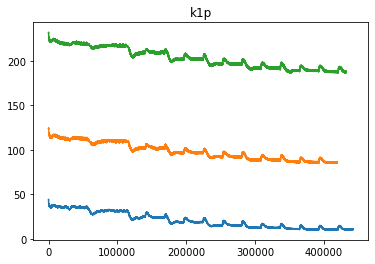

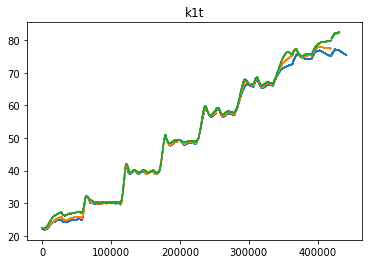

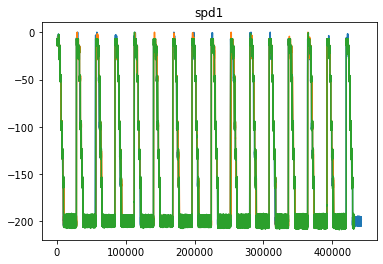

In [4]:
# load raw data and shifts
h5_p30 = h5py.File(file_list_LEM1[2], "r")
filename_p30 = file_list_LEM1[2].split(os.sep)[-1][:-3]
pklName_p30 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p30 + '.pkl'
shift_opts_freqs_all_p30 = pickle.load(open(pklName_p30, 'rb')) 

h5_p100 = h5py.File(file_list_LEM1[0], "r")
filename_p100 = file_list_LEM1[0].split(os.sep)[-1][:-3]
pklName_p100 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p100 + '.pkl'
shift_opts_freqs_all_p100 = pickle.load(open(pklName_p100, 'rb')) 

h5_p200 = h5py.File(file_list_LEM1[1], "r")
filename_p200 = file_list_LEM1[1].split(os.sep)[-1][:-3]
pklName_p200 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p200 + '.pkl'
shift_opts_freqs_all_p200 = pickle.load(open(pklName_p200, 'rb')) 


def plot3(h51,h52,h53,key):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(key)
    ax.plot(h51[key])
    ax.plot(h52[key])
    ax.plot(h53[key])
plot3(h5_p30,h5_p100,h5_p200,'k1p')
plot3(h5_p30,h5_p100,h5_p200,'k1t')
plot3(h5_p30,h5_p100,h5_p200,'spd1')

## Data Extraction

In [5]:
N = 100 # ignore first N points to make the shift possible

spd_p30 = np.round(h5_p30['spd1'][N:],decimals=1)
spd_p100 = np.round(h5_p100['spd1'][N:],decimals=1)
spd_p200 = np.round(h5_p200['spd1'][N:],decimals=1)

pos_p30 = np.round(h5_p30['pos1'][N:],decimals=1)
pos_p100 = np.round(h5_p100['pos1'][N:],decimals=1)
pos_p200 = np.round(h5_p200['pos1'][N:],decimals=1)

k1t_p30 = np.round(h5_p30['k1t'][N:],decimals=1)
k1t_p100 = np.round(h5_p100['k1t'][N:],decimals=1)
k1t_p200 = np.round(h5_p200['k1t'][N:],decimals=1)

ip1k1_p30 = np.round(h5_p30['ip1k1'][N:],decimals=1)
ip1k1_p100 = np.round(h5_p100['ip1k1'][N:],decimals=1)
ip1k1_p200 = np.round(h5_p200['ip1k1'][N:],decimals=1)

len_p30 =pos_p30.shape[0]
len_p100 =pos_p100.shape[0]
len_p200 =pos_p200.shape[0]

print("length:")
print(len_p30)
print(len_p100)
print(len_p100)
print("max:")
print(max(pos_p30))
print(max(pos_p100))
print(max(pos_p200))
print("min:")
print(min(pos_p30))
print(min(pos_p100))
print(min(pos_p200))

length:
441946
419201
419201
max:
124.8
124.8
124.8
min:
-135.0
-134.9
-134.9


In [6]:
s21_p30 = np.array(h5_p30['S21_P1_LEM1'])
dataset_p30 = []
for j in range (121):
    index = np.arange(N,len(h5_p30['t'])) - shift_opts_freqs_all_p30[j,N:].round().astype(int)
    dataset_p30.append(s21_p30[index,j].real)
    dataset_p30.append(s21_p30[index,j].imag)
dataset_p30 = np.array(dataset_p30)

s21_p100 = np.array(h5_p100['S21_P1_LEM1'])
dataset_p100 = []
for j in range (121):
    index = np.arange(N,len(h5_p100['t'])) - shift_opts_freqs_all_p100[j,N:].round().astype(int)
    dataset_p100.append(s21_p100[index,j].real)
    dataset_p100.append(s21_p100[index,j].imag)
dataset_p100 = np.array(dataset_p100)

s21_p200 = np.array(h5_p200['S21_P1_LEM1'])
dataset_p200 = []
for j in range (121):
    index = np.arange(N,len(h5_p200['t'])) - shift_opts_freqs_all_p200[j,N:].round().astype(int)
    dataset_p200.append(s21_p200[index,j].real)
    dataset_p200.append(s21_p200[index,j].imag)
dataset_p200 = np.array(dataset_p200)

print(dataset_p30.shape)
print(dataset_p100.shape)
print(dataset_p200.shape)

(242, 441946)
(242, 419201)
(242, 431830)


In [7]:
h5_p30.close()
h5_p100.close()
h5_p200.close()

## Data Preprocessing for NN Training

### Encoding

In [8]:
X = np.concatenate((dataset_p30.T,dataset_p100.T,dataset_p200.T))
y1 = np.concatenate((pos_p30,pos_p100,pos_p200)).T
y2 = np.concatenate((ip1k1_p30,ip1k1_p100,ip1k1_p200)).T
# y = np.array([y1,y2])

print(X.shape)
print(y1.shape)
print(y2.shape)

(1292977, 242)
(1292977,)
(1292977,)


### End stroke

In [9]:
#  positions bigger or smaller than 100 or 10 mm
p100 = np.where(y1>100)[0]
p10 = np.where(y1>10)[0]
n100 = np.where(y1<-100)[0]
n10 = np.where(y1<-10)[0]

#  positions within in or outside absolute value 100 or 10 mm
pos_in_100 = np.array(list(set(np.arange(y1.shape[0]))-(set(p100)|set(n100))))
pos_out_100 =  np.sort(np.concatenate((p100,n100)))
pos_in_10 = np.array(list(set(np.arange(y1.shape[0]))-(set(p10)|set(n10))))
pos_out_10 =  np.sort(np.concatenate((p10,n10)))

## NN Training with Random Split

### NN Training for Position

In [10]:
GT = ['pos']
Y = y1

### Random Train test split

In [11]:
from sklearn.model_selection import train_test_split

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, Y, indices, test_size=0.2, random_state=42)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1034381, 242)
(1034381,)
(258596, 242)
(258596,)


### 4-hidden-layer NN Model

In [12]:
MODEL_NAME = "NN_pos_all"

In [13]:
# TODO
def NN_all(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(32, kernel_initializer='normal',activation='relu'),
      layers.Dense(16, kernel_initializer='normal',activation='relu'),
      layers.Dense(1,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = tf.keras.metrics.RootMeanSquaredError()
  )
    
  return model

In [14]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = NN_all(normalizer)
NN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 242)               485       
_________________________________________________________________
dense (Dense)                (None, 128)               31104     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 42,470
Trainable params: 41,985
Non-trainable params: 485
__________________________________________________

In [15]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 256,
    # validation_split = 0.125,
    validation_data=(X_test, y_test),
    verbose=0, epochs=50)

Wall time: 37min 41s


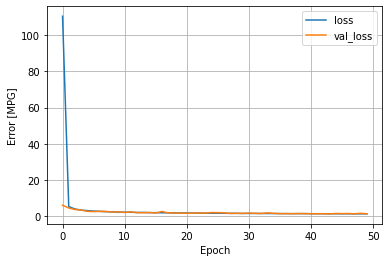

In [16]:
plot_loss(history)

In [17]:
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\all\NN_pos_all\assets


In [18]:
# MODEL_NAME = "NN_pos_all"
# NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [19]:
err_dict = {
    'Output':GT,
    'MSE train' : history.history['loss'][-1],
    'MSE test' : history.history['val_loss'][-1],
    'RMSE train' : history.history['root_mean_squared_error'][-1],
    'RMSE test' : history.history['val_root_mean_squared_error'][-1]
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE train,MSE test,RMSE train,RMSE test
0,pos,1.309058,1.339693,1.144141,1.157451


In [20]:
# evaluation on both training and test sets
y_ = NN.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [21]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = Y[idx_test_sort] - y_test_
err_in_100 = Y[idx_in_100] - y_[idx_in_100].flatten()
err_out_100 = Y[idx_out_100] - y_[idx_out_100].flatten()
err_in_10 = Y[idx_in_10] - y_[idx_in_10].flatten()
err_out_10 = Y[idx_out_10] - y_[idx_out_10].flatten()
err_p100 = Y[idx_p100] - y_[idx_p100].flatten()
err_n100 = Y[idx_n100] - y_[idx_n100].flatten()
err_p10 = Y[idx_p10] - y_[idx_p10].flatten()
err_n10 = Y[idx_n10] - y_[idx_n10].flatten()

In [22]:
# Evaluation of position predictions on end stroke in test set

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:])),
             np.mean(np.square(err_in_100[:])),
             np.mean(np.square(err_out_100[:])),
             np.mean(np.square(err_in_10[:])),
             np.mean(np.square(err_out_10[:])),
             np.mean(np.square(err_p100[:])),
             np.mean(np.square(err_n100[:])),
             np.mean(np.square(err_p10[:])),
             np.mean(np.square(err_n10[:]))],
    
    'std of position predictions' : [np.std(err_test_set[:]),
             np.std(err_in_100[:]),
             np.std(err_out_100[:]),
             np.std(err_in_10[:]),
             np.std(err_out_10[:]),
             np.std(err_p100[:]),
             np.std(err_n100[:]),
             np.std(err_p10[:]),
             np.std(err_n10[:])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,1.339797,1.144632
1,within 100,1.783983,1.308484
2,outside 100,0.781971,0.882786
3,within 10,1.834559,1.349370
4,outside 10,1.314916,1.133289
5,>100,0.618126,0.724986
6,<-100,0.946325,0.951629
7,>10,1.259294,1.022241
8,<-10,1.375166,1.164618


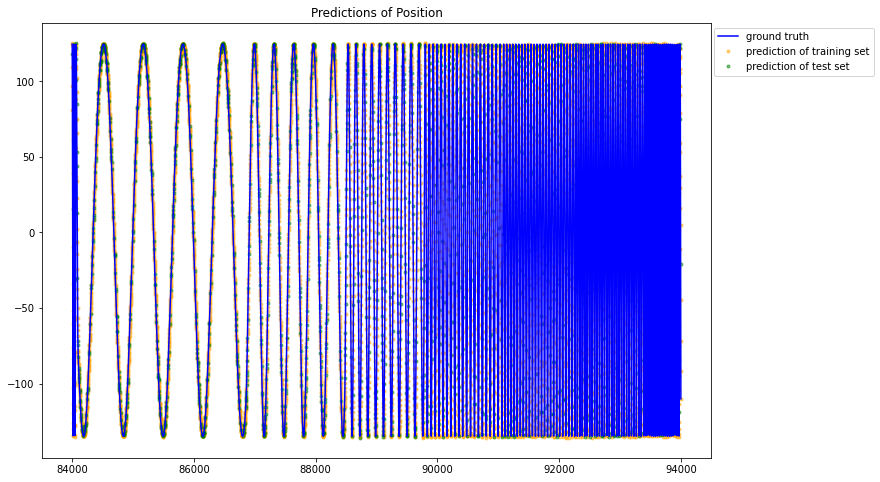

In [23]:
F = 84000
L = F+10000
plot_one_gt_train_test(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

### NN Training for Intermediate Seal Pressure

In [24]:
GT = ['ip1k1']
Y = y2

### Random Train test split

In [25]:
from sklearn.model_selection import train_test_split

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, Y, indices, test_size=0.2, random_state=42)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1034381, 242)
(1034381,)
(258596, 242)
(258596,)


### 4-hidden-layer NN Model

In [26]:
MODEL_NAME = "NN_isp_all"

In [27]:
def NN_all(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim = 242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(32, kernel_initializer='normal',activation='relu'),
      layers.Dense(16, kernel_initializer='normal',activation='relu'),
      layers.Dense(1,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = tf.keras.metrics.RootMeanSquaredError()
  )
  return model

In [28]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = NN_all(normalizer)
NN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_5 (Dense)              (None, 128)               31104     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 42,470
Trainable params: 41,985
Non-trainable params: 485
________________________________________________

In [29]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 256,
    # validation_split = 0.125,
    validation_data=(X_test, y_test),
    verbose=0, epochs=50)

Wall time: 1h 29min 49s


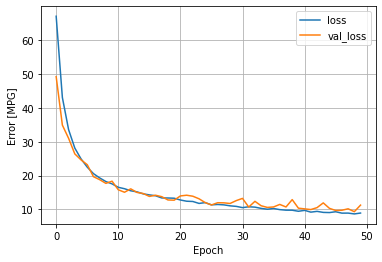

In [30]:
plot_loss(history)

In [31]:
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\all\NN_isp_all\assets


In [32]:
# MODEL_NAME = "NN_isp_all"
# NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [33]:
err_dict = {
    'Output':GT,
    'MSE train' : history.history['loss'][-1],
    'MSE test' : history.history['val_loss'][-1],
    'RMSE train' : history.history['root_mean_squared_error'][-1],
    'RMSE test' : history.history['val_root_mean_squared_error'][-1]
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE train,MSE test,RMSE train,RMSE test
0,ip1k1,8.939437,11.281213,2.989889,3.358752


In [34]:
# evaluation on both training and test sets

y_ = NN.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [35]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = Y[idx_test_sort] - y_test_
err_in_100 = Y[idx_in_100] - y_[idx_in_100].flatten()
err_out_100 = Y[idx_out_100] - y_[idx_out_100].flatten()
err_in_10 = Y[idx_in_10] - y_[idx_in_10].flatten()
err_out_10 = Y[idx_out_10] - y_[idx_out_10].flatten()
err_p100 = Y[idx_p100] - y_[idx_p100].flatten()
err_n100 = Y[idx_n100] - y_[idx_n100].flatten()
err_p10 = Y[idx_p10] - y_[idx_p10].flatten()
err_n10 = Y[idx_n10] - y_[idx_n10].flatten()

In [36]:
# Evaluation of position predictions on end stroke in test set

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:])),
             np.mean(np.square(err_in_100[:])),
             np.mean(np.square(err_out_100[:])),
             np.mean(np.square(err_in_10[:])),
             np.mean(np.square(err_out_10[:])),
             np.mean(np.square(err_p100[:])),
             np.mean(np.square(err_n100[:])),
             np.mean(np.square(err_p10[:])),
             np.mean(np.square(err_n10[:]))],
    
    'std of position predictions' : [np.std(err_test_set[:]),
             np.std(err_in_100[:]),
             np.std(err_out_100[:]),
             np.std(err_in_10[:]),
             np.std(err_out_10[:]),
             np.std(err_p100[:]),
             np.std(err_n100[:]),
             np.std(err_p10[:]),
             np.std(err_n10[:])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,11.280221,3.349720
1,within 100,11.278152,3.353158
2,outside 100,11.282819,3.343951
3,within 10,10.993158,3.314234
4,outside 10,11.294658,3.350589
5,>100,6.437493,2.522420
6,<-100,16.143215,4.001566
7,>10,8.570841,2.921596
8,<-10,14.245109,3.758824


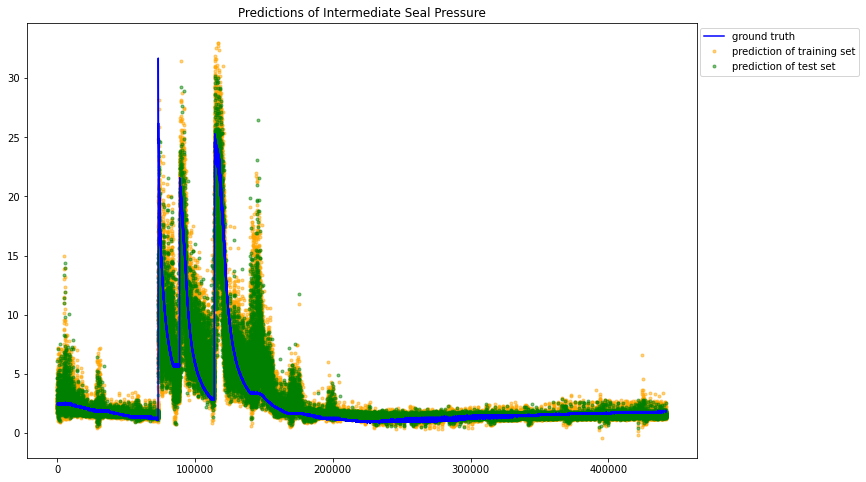

In [37]:
F = 0
L = len_p30

plot_one_gt_train_test(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Intermediate Seal Pressure")

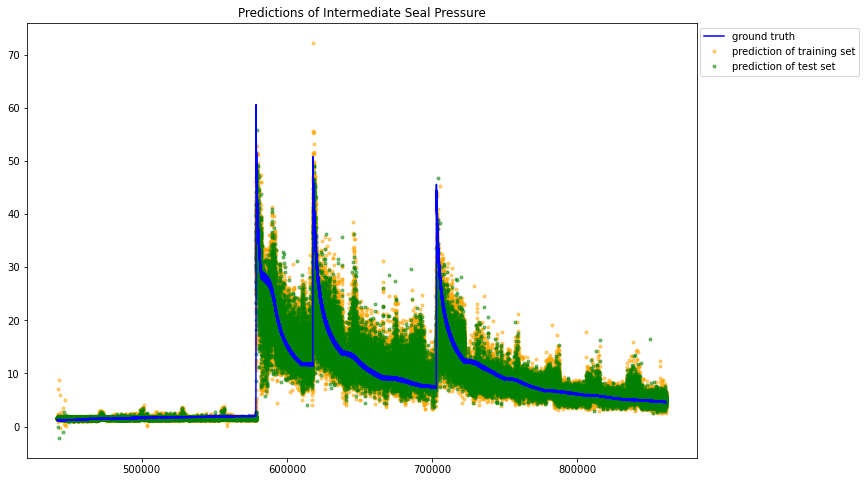

In [38]:
F = L
L = F + len_p100

plot_one_gt_train_test(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Intermediate Seal Pressure")

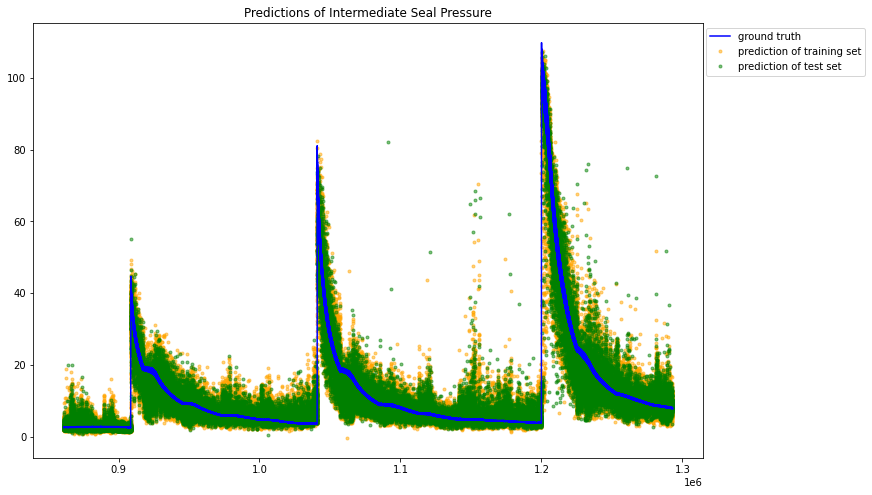

In [39]:
F = L
L = F + len_p200

plot_one_gt_train_test(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Intermediate Seal Pressure")

## NN Training with Split considering Temperatur

### NN Training for Position

In [40]:
GT = ['pos']
Y = y1

###  Split considering temperatur

According to the test plan, 3 datasets in V27 are all evenly divided into 8 segments by 8 different temperature levels.
(range(20,90,10). The rule is not perfectly followed in real world, see figures at the beginning of this notebook.)

In order to eliminate the influence of temperature, we use 80-20 split for each segement.


In [41]:
f = np.array([i*len_p30//8 for i in range(8)])
l =f + len_p30//8//5*4
idx_p30 = np.hstack([np.arange(f[i],l[i]) for i in range (8)])

f = np.array([i*len_p100//8 for i in range(8)])+len_p30
l =f + len_p100//8//5*4
idx_p100 = np.hstack([np.arange(f[i],l[i]) for i in range (8)])

f = np.array([i*len_p200//8 for i in range(8)])+len_p30+len_p100
l =f + len_p200//8//5*4
idx_p200 = np.hstack([np.arange(f[i],l[i]) for i in range (8)])

idx_train_sort = np.hstack([idx_p30,idx_p100,idx_p200])
idx_test_sort = np.sort((list(set(np.arange(len_p100 + len_p30 + len_p200))-set(idx_train_sort))))

X_train = X[idx_train_sort]
X_test = X[idx_test_sort]
y_train = Y[idx_train_sort]
y_test = Y[idx_test_sort]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1034336, 242)
(1034336,)
(258641, 242)
(258641,)


### 4-hidden-layer NN Model

In [42]:
MODEL_NAME = "NN_pos_all_8020T"

In [43]:
# TODO
def NN_all(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(32, kernel_initializer='normal',activation='relu'),
      layers.Dense(16, kernel_initializer='normal',activation='relu'),
      layers.Dense(1,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = tf.keras.metrics.RootMeanSquaredError()
  )
    
  return model

In [44]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = NN_all(normalizer)
NN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_10 (Dense)             (None, 128)               31104     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 42,470
Trainable params: 41,985
Non-trainable params: 485
________________________________________________

In [45]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 256,
    # validation_split = 0.125,
    validation_data=(X_test, y_test),
    verbose=0, epochs=50)

Wall time: 1h 24min 35s


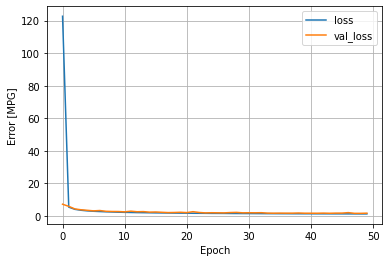

In [46]:
plot_loss(history)

In [47]:
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\all\NN_pos_all_8020T\assets


In [48]:
# MODEL_NAME = "NN_pos_all_8020T"
# NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [49]:
err_dict = {
    'Output':GT,
    'MSE train' : history.history['loss'][-1],
    'MSE test' : history.history['val_loss'][-1],
    'RMSE train' : history.history['root_mean_squared_error'][-1],
    'RMSE test' : history.history['val_root_mean_squared_error'][-1]
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE train,MSE test,RMSE train,RMSE test
0,pos,1.233045,1.69432,1.110425,1.30166


In [50]:
# evaluation on both training and test sets

y_ = NN.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [51]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = Y[idx_test_sort] - y_test_
err_in_100 = Y[idx_in_100] - y_[idx_in_100].flatten()
err_out_100 = Y[idx_out_100] - y_[idx_out_100].flatten()
err_in_10 = Y[idx_in_10] - y_[idx_in_10].flatten()
err_out_10 = Y[idx_out_10] - y_[idx_out_10].flatten()
err_p100 = Y[idx_p100] - y_[idx_p100].flatten()
err_n100 = Y[idx_n100] - y_[idx_n100].flatten()
err_p10 = Y[idx_p10] - y_[idx_p10].flatten()
err_n10 = Y[idx_n10] - y_[idx_n10].flatten()

In [52]:
# Evaluation of position predictions on end stroke in test set

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:])),
             np.mean(np.square(err_in_100[:])),
             np.mean(np.square(err_out_100[:])),
             np.mean(np.square(err_in_10[:])),
             np.mean(np.square(err_out_10[:])),
             np.mean(np.square(err_p100[:])),
             np.mean(np.square(err_n100[:])),
             np.mean(np.square(err_p10[:])),
             np.mean(np.square(err_n10[:]))],
    
    'std of position predictions' : [np.std(err_test_set[:]),
             np.std(err_in_100[:]),
             np.std(err_out_100[:]),
             np.std(err_in_10[:]),
             np.std(err_out_10[:]),
             np.std(err_p100[:]),
             np.std(err_n100[:]),
             np.std(err_p10[:]),
             np.std(err_n10[:])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,1.694006,1.301381
1,within 100,2.191280,1.474089
2,outside 100,1.063560,1.023610
3,within 10,2.628000,1.610643
4,outside 10,1.646371,1.282742
5,>100,1.030291,0.823203
6,<-100,1.097465,0.986868
7,>10,1.463221,1.176011
8,<-10,1.846413,1.306444


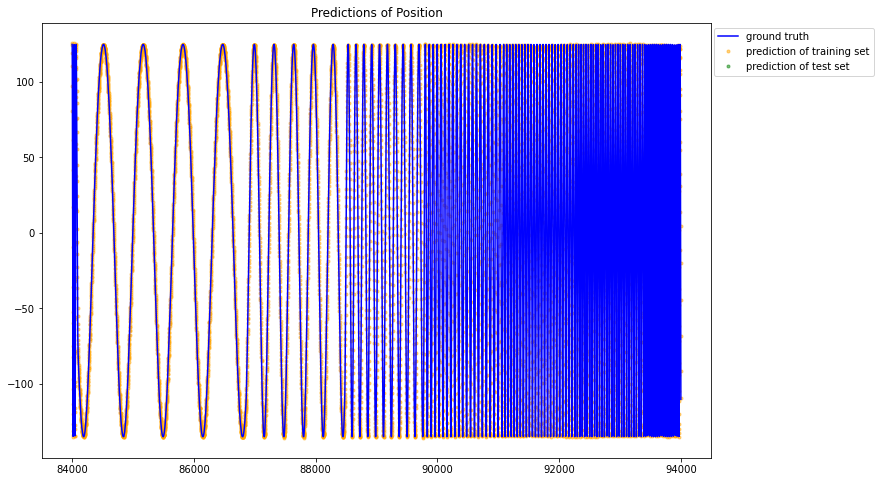

In [53]:
F = 84000
L = F+10000
plot_one_gt_train_test(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

### NN Training for Intermediate Seal Pressure

In [54]:
GT = ['pos']
Y = y2

###  Split considering temperatur

According to the test plan, 3 datasets in V27 are all evenly divided into 8 segments by 8 different temperature levels.
(range(20,90,10). The rule is not perfectly followed in real world, see figures at the beginning of this notebook.)

In order to eliminate the influence of temperature, we use 80-20 split for each segement.


In [55]:
f = np.array([i*len_p30//8 for i in range(8)])
l =f + len_p30//8//5*4
idx_p30 = np.hstack([np.arange(f[i],l[i]) for i in range (8)])

f = np.array([i*len_p100//8 for i in range(8)])+len_p30
l =f + len_p100//8//5*4
idx_p100 = np.hstack([np.arange(f[i],l[i]) for i in range (8)])

f = np.array([i*len_p200//8 for i in range(8)])+len_p30+len_p100
l =f + len_p200//8//5*4
idx_p200 = np.hstack([np.arange(f[i],l[i]) for i in range (8)])

idx_train_sort = np.hstack([idx_p30,idx_p100,idx_p200])
idx_test_sort = np.sort((list(set(np.arange(len_p100 + len_p30 + len_p200))-set(idx_train_sort))))

X_train = X[idx_train_sort]
X_test = X[idx_test_sort]
y_train = Y[idx_train_sort]
y_test = Y[idx_test_sort]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1034336, 242)
(1034336,)
(258641, 242)
(258641,)


### 4-hidden-layer NN Model

In [56]:
MODEL_NAME = "NN_isp_all_8020T"

In [57]:
# TODO
def NN_all(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(32, kernel_initializer='normal',activation='relu'),
      layers.Dense(16, kernel_initializer='normal',activation='relu'),
      layers.Dense(1,activation='linear')
  ])
  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = tf.keras.metrics.RootMeanSquaredError()
  )
  return model

In [58]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = NN_all(normalizer)
NN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_15 (Dense)             (None, 128)               31104     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 42,470
Trainable params: 41,985
Non-trainable params: 485
________________________________________________

In [59]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 256,
    # validation_split = 0.125,
    validation_data=(X_test, y_test),
    verbose=0, epochs=50)

Wall time: 31min 38s


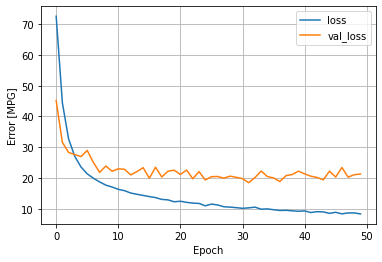

In [60]:
plot_loss(history)

In [61]:
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\all\NN_isp_all_8020T\assets


In [62]:
# MODEL_NAME = "NN_isp_all_8020T"
# NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [63]:
err_dict = {
    'Output':GT,
    'MSE train' : history.history['val_loss'][-1],
    'MSE test' : history.history['val_loss'][-1],
    'RMSE train' : history.history['root_mean_squared_error'][-1],
    'RMSE test' : history.history['val_root_mean_squared_error'][-1]
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE train,MSE test,RMSE train,RMSE test
0,pos,21.302416,21.302416,2.888407,4.615454


In [64]:
# evaluation on both training and test sets

y_ = NN.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [65]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = Y[idx_test_sort] - y_test_
err_in_100 = Y[idx_in_100] - y_[idx_in_100].flatten()
err_out_100 = Y[idx_out_100] - y_[idx_out_100].flatten()
err_in_10 = Y[idx_in_10] - y_[idx_in_10].flatten()
err_out_10 = Y[idx_out_10] - y_[idx_out_10].flatten()
err_p100 = Y[idx_p100] - y_[idx_p100].flatten()
err_n100 = Y[idx_n100] - y_[idx_n100].flatten()
err_p10 = Y[idx_p10] - y_[idx_p10].flatten()
err_n10 = Y[idx_n10] - y_[idx_n10].flatten()

In [66]:
# Evaluation of position predictions on end stroke in test set

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:])),
             np.mean(np.square(err_in_100[:])),
             np.mean(np.square(err_out_100[:])),
             np.mean(np.square(err_in_10[:])),
             np.mean(np.square(err_out_10[:])),
             np.mean(np.square(err_p100[:])),
             np.mean(np.square(err_n100[:])),
             np.mean(np.square(err_p10[:])),
             np.mean(np.square(err_n10[:]))],
    
    'std of position predictions' : [np.std(err_test_set[:]),
             np.std(err_in_100[:]),
             np.std(err_out_100[:]),
             np.std(err_in_10[:]),
             np.std(err_out_10[:]),
             np.std(err_p100[:]),
             np.std(err_n100[:]),
             np.std(err_p10[:]),
             np.std(err_n10[:])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,21.302921,4.615489
1,within 100,23.755018,4.873370
2,outside 100,18.194147,4.265028
3,within 10,26.485697,5.143407
4,outside 10,21.038593,4.586781
5,>100,13.793672,3.709215
6,<-100,22.678682,4.761711
7,>10,18.573032,4.309559
8,<-10,23.731548,4.871329


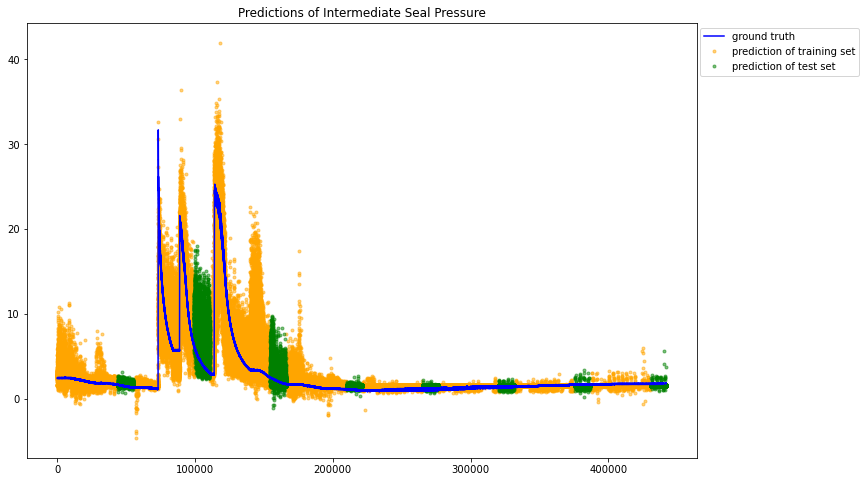

In [67]:
F = 0
L = len_p30

plot_one_gt_train_test(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Intermediate Seal Pressure")

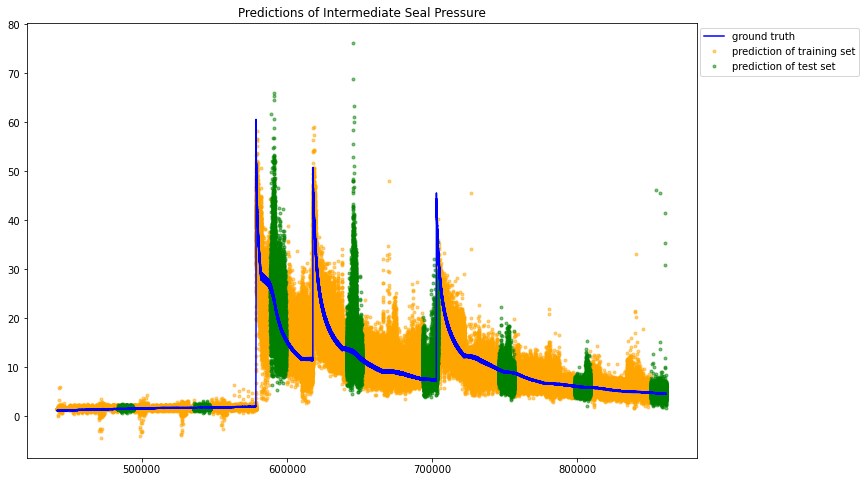

In [68]:
F = L
L = F + len_p100

plot_one_gt_train_test(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Intermediate Seal Pressure")

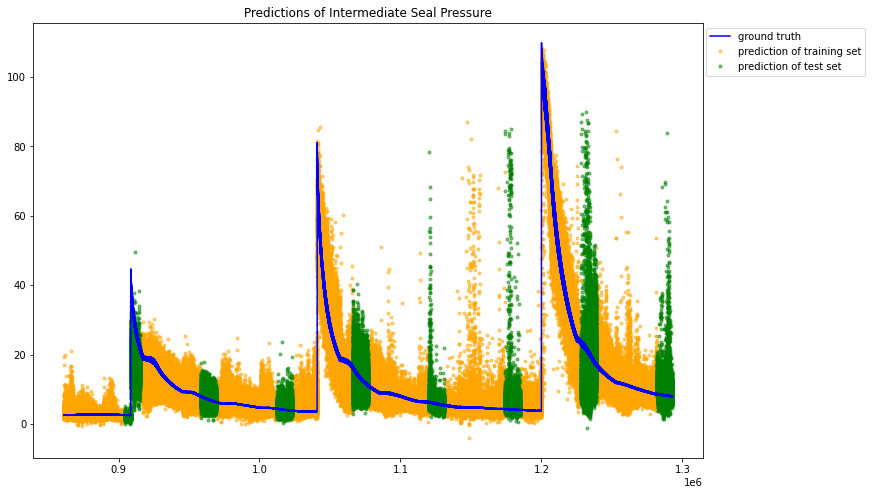

In [69]:
F = L
L = F + len_p200

plot_one_gt_train_test(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Intermediate Seal Pressure")